<a href="https://colab.research.google.com/github/irbahasf14/SentimentAnalysis/blob/main/Sentiment_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Sentimen Nasabah terhadap Pelayanan PT. Bank Mandiri (TBK) dengan Metode Regresi Logistik Biner**



* Maulana Akbar Ibrahim 
* Petra Bayu Pangestu 
* Carica Deffa Yullinda 
* Devito Karunia Susilo 
* Irbah Asfarina 
* Rama Destrian Hartadi 
* Setyo Aji Pratomo 


In [ ]:
#Import Library

import math
import csv
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

In [ ]:
#Load Dataset

data_training = pd.read_csv('tweetbankmandiri.csv')
y_train = data_training['sentimen']
x_train = data_training.drop(['sentimen'], axis=1)

In [ ]:
#Preprocessing, Feature Extraction & Representation

def cut_and_fold(teks):
    for i in range(len(teks)):
        teks[i] = teks[i].lower()
        #teks[i] = teks[i].strip()
        teks[i] = teks[i].strip("?.,/:;!~`!@#$%^&*()_+=-[]{}|<>")
        teks[i] = teks[i].replace("'", "")
        teks[i] = teks[i].replace('"', '')
        teks[i] = ''.join((x for x in teks[i] if not x.isdigit()))
        re.sub('(?:\s)@[^, ]*', '', teks[i])
        re.sub('(?:\s)http[^, ]*', '', teks[i])
    return teks

def filtering(teks, theStopWords):
    hasil = []
    for sentence in teks:
        oneWord = sentence.split()
        for word in oneWord:
            if word not in theStopWords:    #filtering
                hasil.append(word)
    hasil = list(dict.fromkeys(hasil))  #menghilangkan duplikat
    return hasil

def delete_inflection_suffixes(word):
    if len(word)>5:
        if word.endswith("tah") or word.endswith("lah") or word.endswith("pun") or word.endswith("kah"):
            result = word[:-(3)]
        if word.endswith("mu") or word.endswith("ku"):
            result = word[:-(2)]
        if word.endswith("nya"):
            result = word[:-(3)]
    else:
        result = word
    return result

def delete_derivation_suffixes(word, kamus):
    if word.endswith("i") and word not in kamus:
        result = word[:-(1)]
    elif word.endswith("kan") and len(word)>5:
        result = word[:-(3)]
    elif word.endswith("an") and len(word)>5:
        result = word[:-(2)]
    else:
        result = word
    return result

def delete_derivation_prefixes(word, kamus):
    if (word.startswith("di") or word.startswith("ke") or word.startswith("se")) and len(word)>5:
        result = word[+(2):]
    elif word.startswith("ber"):
        result = word.replace("ber","r")
        if result not in kamus:
            result = word.replace("ber","")
    elif word.startswith("nge"):
        result = word.replace("nge", "")
    elif word.startswith("ter"):
        result = word.replace("ter","r")
        if result not in kamus:
            result = word.replace("ter","")
    elif word.startswith("mel") or word.startswith("mer") or word.startswith("mew") or word.startswith("mey"):
        result = word.replace("me","")
    elif word.startswith("memb") or word.startswith("memf") or word.startswith("memv") or word.startswith("mempe"):
        result = word.replace("mem","")
    elif word.startswith("memr"):
        result = word.replace("mem","p")
    elif word.startswith("mema") or word.startswith("memi") or word.startswith("meme") or word.startswith("memu") or word.startswith("memo"):
        result = word.replace("mem", "p")
        if result not in kamus:
            result = word.replace("mem", "m")
    elif word.startswith("menc") or word.startswith("mend") or word.startswith("menj") or word.startswith("mens") or word.startswith("menz"):
        result = word.replace("men","")
    elif word.startswith("mena") or word.startswith("meni") or word.startswith("menu") or word.startswith("mene") or word.startswith("meno"):
        result = word.replace("men", "t")
        if result not in kamus:
            result = word.replace("men", "n")
    elif word.startswith("mengh") or word.startswith("mengg") or word.startswith("mengk") or word.startswith("mengq"):
            result = word.replace("meng", "")
    elif word.startswith("menga") or word.startswith("menge") or word.startswith("mengi") or word.startswith("mengu") or word.startswith("mengo"):
            result = word.replace("meng","k")
            if result not in kamus:
                result = word.replace("meng","")
    elif word.startswith("meny"):
        result = word.replace("meny", "s")
    elif word.startswith("pew") or word.startswith("pey"):
        result = word.replace("pe", "")
    elif word.startswith("per"):
        result = word.replace("per","r")
        if result not in kamus:
            result = word.replace("per","")
    elif word.startswith("pemb") or word.startswith("pemf"):
        result = word.replace("pem", "")
    elif word.startswith("pema") or word.startswith("pemi") or word.startswith("pemu") or word.startswith("peme") or word.startswith("pemo"):
        result = word.replace("pem", "m")
        if result not in kamus:
            result = word.replace("pem", "p")
    elif word.startswith("penc") or word.startswith("pend") or word.startswith("penj") or word.startswith("penz"):
        result = word.replace("pen","")
    elif word.startswith("pena") or word.startswith("peni") or word.startswith("penu") or word.startswith("pene") or word.startswith("peno"):
        result = word.replace("pen","t")
        if result not in kamus:
            result = word.replace("pen","n")
    elif word.startswith("peng"):
        result = word.replace("peng","")
        if result not in kamus:
            result = word.replace("peng", "k")
    elif word.startswith("peny"):
        result = word.replace("peny","s")
    elif word.startswith("pel"):
        if word == "pelajar":
            result = word.replace("pel","")
        else:
            result = word.replace("pe","")
    elif word.startswith("pep"):
        result = word.replace("pep","p")
    else:
        result = word
    return result

def stemming(bagOfWords): #menggunakan algoritma Nazief & Andriani
    newBag = []
    with open('katadasar.txt') as k:
      kamusKataDasar = [line.strip() for line in k if line.strip()]
      for word in bagOfWords:
          if word in kamusKataDasar:
              newBag.append(word)
          else:
              if word == 'bisaaaaaaaaa':
                  word = word.replace('bisaaaaaaaaa', 'bisa')
              if word == 'errorrrr':
                  word = word.replace('errorrrr', 'eror')
              if word == 'cehek':
                  word = word.replace('cehek', 'cek')
              if word == 'free':
                  word = word.replace('free', 'gratis')
              if word == 'nyusahin':
                  word = word.replace('nyusahin', 'susah')
              if word == 'reply':
                  word = word.replace('reply', 'balas')
              if word == 'nipu':
                  word = word.replace('nipu', 'tipu')
              if word == 'diem':
                  word = word.replace('diem', 'diam')
              if word == 'bener':
                  word = word.replace('bener', 'benar')
              if word == 'login':
                  word = word.replace('login', 'masuk')
              if word == 'bodong':
                  word = word.replace('bodong', 'tipu')
              if word == 'kontol':
                  word = word.replace('kontol', 'bodoh')
              if word == 'goblok':
                  word = word.replace('goblok', 'bodoh')
              if word == 'maintenance':
                  word = word.replace('maintenance', 'rawat')
              if word == 'report':
                  word = word.replace('report', 'lapor')
              if word == 'terimakasih':
                  word = word.replace('terimakasih', 'terima kasih')
                  #newBag.append(word)
              if word == 'makasih':
                  word = word.replace('makasih', 'terima kasih')
                  #newBag.append(word)
              if word == 'down':
                  word = word.replace('down', 'masalah')
              if word == 'asset':
                  word = word.replace('asset', 'aset')
              if word == 'nanya':
                  word = word.replace('nanya', 'tanya')
              if word.endswith("ku") or word.endswith("mu") or word.endswith("nya") or word.endswith("lah") or word.endswith("tah") or word.endswith("kah") or word.endswith("pun"):
                  word = word = delete_inflection_suffixes(word)
              if word.startswith("di") or word.startswith("ke") or word.startswith("se") or word.startswith("me") or word.startswith("be") or word.startswith("pe") or word.startswith("te") or word.startswith("nge"):
                  if word not in kamusKataDasar:
                      word = delete_derivation_prefixes(word, kamusKataDasar)
              if word.endswith("an") or word.endswith("kan") or word.endswith("i"):
                  word = delete_derivation_suffixes(word, kamusKataDasar)
              if word in kamusKataDasar:
                  newBag.append(word)
    newBag = list(dict.fromkeys(newBag))
    return newBag
 
def hitung_tfidf(bagOfWords, teks, theStopWords):
  #hitung tf
  length = len(bagOfWords)
  print("length of bag: "+str(length))
  tf_count = []
  stemmedList = []
  i = 0
  while i<len(teks):
    tempList = [0] * length
    eachDocument = []
    theDoc = teks[i].split()
    #print(theDoc)
    for word in theDoc:
        if word not in theStopWords:
            eachDocument.append(word)
    #print(eachDocument)
    eachDocument = stemming(eachDocument)
    for a in eachDocument:
      if a in bagOfWords:
        stemmedList.append(a)
    #print(eachDocument)
    for word in eachDocument:
      if word in bagOfWords:
          tempList[bagOfWords.index(word)] = tempList[bagOfWords.index(word)]+1
    #print(tempList)
    tf_count.append(tempList)
    i+=1
  #print(tf_count)
  #hitung idf
  idf_count = []
  for word in bagOfWords:
    wordAppearance = 0
    m = 0
    while m < len(stemmedList):
        if word in stemmedList[m]:
            wordAppearance += 1
        m += 1
    if wordAppearance == 0:
      wordAppearance = wordAppearance + 10*len(stemmedList)
    idf = 1 + math.log((len(stemmedList) / wordAppearance),10)
    idf_count.append(idf)
  print("idf= "+str(idf_count))
  print("tf= "+str(tf_count))
  #hitung tf-idf
  j=0
  tf_idf = []
  for tf in tf_count:
    index = 0
    result = [0] * length
    while index<len(idf_count):
        result[index] = tf[index] * idf_count[index]
        index+=1
    tf_idf.append(result)
  #print("tf-idf = "+str(tf_idf))
  #print("Hasil TF-IDF: ")
  '''
  kalimat = 1
  for eachDoc in tf_idf:
    print("Kalimat "+str(kalimat)+": "+str(eachDoc))
    kalimat+=1
  #print(len(tf_idf))
  '''
  return tf_idf

teks = x_train['teks'] #[line.strip() for line in x_train if line.strip()]
theStopWords = ["adalah", "aduh", "agak", "agar", "akan", "aku", "amat", "anda", "apa", "apakah", "apalah", "apalagi",
                "asal", "atau", "ataukah", "ayah", "ayo", "bagaimana", "bahkan", "bahwa", "bapak", "begitu",
                "begitukah", "begitulah", "beliau", "betapa", "biasanya", "bila", "bunda", "dan", "dari", "demikian", "dengan", "di", "dia", 'mah',
                "dimana", "duhai", "guna", "ha", "hah", "hai", "halo", "hanya", "hingga", "huh", "ia", "ialah", "ibu", 'benar', 'turut', 'kemarin', 'bagai',
                "ini", "iya", "itu", "jadi", "jangankan", "jarang", "jika", "jikalau", "juga", "kala", "kalau", "kalian", "kami", 'kalo', 'jadi', 'mana',
                "kamu", "kan", "kapan", "karena", "kau", "ke", "kecuali", "kemana", "kemudian", "kenapa", "kerap", "ketika", "kian", "kita", 'ni', 'kek', 'macam',
                "kok", "lagipula", "laksana", "lalu", "maka", "malah", "malahan", "melainkan", "melakukan", "mengapa", "mereka", "misal", "misalkan", "nah",
                "namun", "oh", "oleh", "pada", "padahal", "pernah", "pula", "pun", "qrt", "rt", "rupanya", "saat", "sampai", "sang", 'sempat', 'bagai', 'wa',
                "sangat", "saya", "sebab", "sebagai", "sebaliknya", "sebelum", "secara", "sedang", "sedangkan", "sehingga", "selalu", 'terus,', 'hari', 'uda', 'sol',
                "selanjutnya", "semisal", "seolah", "seperti", "semakin", "sering", "serta", "sesudah", "setelah", "sewaktu", "si", "siapa", "sudah", "supaya",
                "tak", "tatkala", "telah", "tempat", "ternyata", "tetapi", "tidak", "toh", "tuh", "untuk", "wah", "wahai", "waduh", 'min', 'para', 'gin', 'cuman',
                "ya", "yang", "yaitu", "yakni", "yuk", 'nih', 'lalu', 'pan', 'lo', 'ka', 'kak', 'bang', 'mas', 'mba', 'mbak', 'pak', 'bu', 'bapak', 'ibu', 'lagi',
                "satu", "dua", "tiga", "empat", "lima", "enam", "tujuh", "delapan", "sembilan", "sepuluh", "puluh", "puluhan", "nol", 'aja', 'saja', 'duh', 'tapi',
                "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", 'jadi']

In [ ]:
#Modeling

cut_and_fold(teks)
#print(teks)
bagOfWords = filtering(teks, theStopWords)
#print(bagOfWords)
bagOfWords = stemming(bagOfWords)
print(bagOfWords)
feature = hitung_tfidf(bagOfWords, teks, theStopWords)
#feature = pd.DataFrame(feature)

# X_train, X_test, y_train, y_test = train_test_split(feature, y_train, test_size=0.2, random_state=42)
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model.fit(feature, y_train)
cv=KFold(n_splits = 10)
accuracy = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="accuracy")
precision = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="precision")
recall = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="recall")
# y_pred = cross_val_predict(model, X=feature, y=y_train, cv=cv)
# conf_mat = confusion_matrix(y_train, y_pred)

print("-------Accuracy Score-----------")
i=1
for ac in accuracy:
  print(str(i)+" : "+str(ac))
  i+=1
print("-------Precision Score-----------")
j=1
for prec in precision:
  print(str(j)+" : "+str(prec))
  j+=1

print("-------Recall Score-----------")
k=1
for rec in recall:
  print(str(k)+" : "+str(rec))
  k+=1

print("Mean Accuracy: "+str(accuracy.mean()))
print("Mean Precision: "+str(precision.mean()))
print("Mean Recall: "+str(recall.mean()))

['terima kasih', 'masa', 'mau', 'tanya', 'ikut', 'atas', 'pihak', 'bank', 'kelompok', 'tipu', 'lomba', 'foto', 'buru', 'sempat', 'raih', 'nilai', 'total', 'mantap', 'aset', 'besar', 'keren', 'layan', 'pos', 'transaksi', 'ban', 'jasa', 'tolong', 'belanja', 'eror', 'terus', 'mandiri', 'jam', 'gin', 'tiket', 'musikal', 'rawat', 'biasa', 'tengah', 'malam', 'developer', 'buat', 'masuk', 'begini', 'langsung', 'super', 'warna', 'kuning', 'jangan', 'rusak', 'reputasi', 'ada', 'bayar', 'koja', 'bisa', 'kendala', 'kah', 'mulai', 'unjuk', 'transfer', 'vespa', 'jadi', 'baik', 'dalam', 'daftar', 'versi', 'capai', 'permisi', 'tiap', 'top', 'tulis', 'hasil', 'tambah', 'ambil', 'galeri', 'menu', 'susah', 'balas', 'isi', 'klik', 'baru', 'kasih', 'debit', 'syarat', 'resmi', 'kontol', 'goblok', 'akun', 'terima', 'pakan', 'waktu', 'turut', 'lalu', 'lama', 'benar', 'informasi', 'bantu', 'kait', 'alami', 'sila', 'lanjut', 'warga', 'negara', 'asing', 'kata', 'takut', 'menit', 'mati', 'diam', 'maaf', 'mohon',

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------Accuracy Score-----------
1 : 0.8
2 : 0.9
3 : 0.7
4 : 0.6
5 : 0.7
6 : 0.7
7 : 0.9
8 : 0.3
9 : 0.7
10 : 0.8
-------Precision Score-----------
1 : 0.8
2 : 1.0
3 : 1.0
4 : 0.0
5 : 0.25
6 : 0.7142857142857143
7 : 0.75
8 : 1.0
9 : 1.0
10 : 0.5
-------Recall Score-----------
1 : 0.8
2 : 0.6666666666666666
3 : 0.5
4 : 0.0
5 : 1.0
6 : 0.8333333333333334
7 : 1.0
8 : 0.125
9 : 0.4
10 : 0.5
Mean Accuracy: 0.71
Mean Precision: 0.7014285714285714
Mean Recall: 0.5825000000000001


In [ ]:
#Prediction in Data Test

data_testing = pd.read_csv('mandiridatatest2.csv')
text = data_testing['teks']
cut_and_fold(text)
filtering(text, theStopWords)
test_feature = hitung_tfidf(bagOfWords, text, theStopWords)
test_feature = pd.DataFrame(test_feature)

result = model.predict(test_feature) #memprediksi sentimen dari data test

length of bag: 237
idf= [2.7283537820212285, 2.220446049250313e-16, 2.427323786357247, 3.0293837776852093, 2.220446049250313e-16, 3.0293837776852093, 2.7283537820212285, 2.126293790693266, 2.220446049250313e-16, 2.7283537820212285, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 3.0293837776852093, 2.220446049250313e-16, 2.220446049250313e-16, 2.0293837776852097, 2.220446049250313e-16, 2.7283537820212285, 2.220446049250313e-16, 3.0293837776852093, 2.220446049250313e-16, 1.9154404253783728, 3.0293837776852093, 3.0293837776852093, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 3.0293837776852093, 3.02938377

In [ ]:
#Simpan ke CSV

indeks = 0
while indeks < len(text): 
  tambah_satu_data = open('hasilanalisis.csv', 'a', newline='\n')
  sentimen = result[indeks]
  isi = text[indeks]
  simpan_satu_data = csv.writer(tambah_satu_data)
  simpan_satu_data.writerow([sentimen, isi]) 
  indeks += 1

In [ ]:
result

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])

# Experiment lain

In [ ]:
#--------------------MODELING---------------------------
cut_and_fold(teks)
#print(teks)
bagOfWords = filtering(teks, theStopWords)
#print(bagOfWords)
bagOfWords = stemming(bagOfWords)
print(bagOfWords)
feature = hitung_tfidf(bagOfWords, teks, theStopWords)
#feature = pd.DataFrame(feature)

X_train, X_test, y_train, y_test = train_test_split(feature, y_train, test_size=0.2, random_state=42)
# model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# model.fit(X_train, y_train)
# cv=KFold(n_splits = 10)
# accuracy = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="accuracy")
# precision = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="precision")
# recall = cross_val_score(model, X=feature, y=y_train, cv=cv, scoring="recall")
# y_pred = cross_val_predict(model, X=X_train, y=y_train, cv=cv)
# conf_mat = confusion_matrix(y_train, y_pred)

# print("-------Accuracy Score-----------")
# i=1
# for ac in accuracy:
#   print(str(i)+" : "+str(ac))
#   i+=1
# print("-------Precision Score-----------")
# j=1
# for prec in precision:
#   print(str(j)+" : "+str(prec))
#   j+=1

# print("-------Recall Score-----------")
# k=1
# for rec in recall:
#   print(str(k)+" : "+str(rec))
#   k+=1

print("Logistic Regression Model Score:" + str(model.score(X_test, y_test)))
# print("Mean Accuracy: "+str(accuracy.mean()))
# print("Mean Precision: "+str(precision.mean()))
# print("Mean Recall: "+str(recall.mean()))

y_pred_logistic  = model.predict(X_test)
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_logistic, labels=[1,0])



['terima kasih', 'masa', 'mau', 'tanya', 'ikut', 'atas', 'pihak', 'bank', 'kelompok', 'tipu', 'lomba', 'foto', 'buru', 'sempat', 'raih', 'nilai', 'total', 'mantap', 'aset', 'besar', 'keren', 'layan', 'pos', 'transaksi', 'ban', 'jasa', 'tolong', 'belanja', 'eror', 'terus', 'mandiri', 'jam', 'gin', 'tiket', 'musikal', 'rawat', 'biasa', 'tengah', 'malam', 'developer', 'buat', 'masuk', 'begini', 'langsung', 'super', 'warna', 'kuning', 'jangan', 'rusak', 'reputasi', 'ada', 'bayar', 'koja', 'bisa', 'kendala', 'kah', 'mulai', 'unjuk', 'transfer', 'vespa', 'jadi', 'baik', 'dalam', 'daftar', 'versi', 'capai', 'permisi', 'tiap', 'top', 'tulis', 'hasil', 'tambah', 'ambil', 'galeri', 'menu', 'susah', 'balas', 'isi', 'klik', 'baru', 'kasih', 'debit', 'syarat', 'resmi', 'kontol', 'goblok', 'akun', 'terima', 'pakan', 'waktu', 'turut', 'lalu', 'lama', 'benar', 'informasi', 'bantu', 'kait', 'alami', 'sila', 'lanjut', 'warga', 'negara', 'asing', 'kata', 'takut', 'menit', 'mati', 'diam', 'maaf', 'mohon',

Text(0.5, 1.0, 'Confusion Matrix Regresi Logistik')

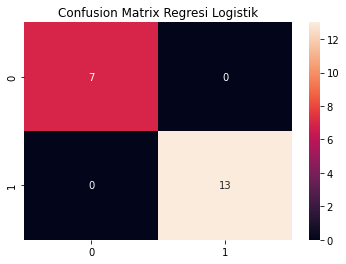

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix_logistic, annot=True, fmt="d")
ax.set_title('Confusion Matrix Regresi Logistik')